In [45]:
import pandas as pd
import numpy as np
import os
import sys
sys.path.append("../code/data_processing/name_resolution/")
from resolved_names_curator import ResolvedNamesCurator

import matplotlib.pyplot as plt
from ete3 import Tree

In [46]:
group_by = "genus"

polyploidy_threshold = 0.75
diploidy_threshold = 0.25

conservative_ploidb_path = f"/groups/itay_mayrose/halabikeren/PloiDB/chromevol/results/with_model_weighting/ploidb_by_{group_by}_without_missing.csv"
with_missing_ploidb_path = f"/groups/itay_mayrose/halabikeren/PloiDB/chromevol/results/with_model_weighting/ploidb_by_{group_by}_with_missing.csv"
qdb_path = "/groups/itay_mayrose/halabikeren/PloiDB/chromevol/results/cvalues_db.csv"

unresolved_plant_names_path = f"../data/name_resolution/unresolved_plant_names.csv"
resolved_plant_names_path = f"/groups/itay_mayrose/halabikeren/plant_pollinator_networks/name_resolution/resolved_plant_names.csv"

tree_path = "/groups/itay_mayrose/halabikeren/PloiDB/trees/ALLMB.tre"
ccdb_path = "/groups/itay_mayrose/halabikeren/PloiDB/ccdb/all_data_with_ALLMB_mapped_names.csv"
classification_data_path = "/groups/itay_mayrose/halabikeren/PloiDB/trees/wfo_classification_data.csv"
missing_names_path = "/groups/itay_mayrose/halabikeren/PloiDB/trees/names_to_add_for_ppn_project.csv"

networks_types = ["weighted", "binary"]
all_networks_dir = "/groups/itay_mayrose/halabikeren/plant_pollinator_networks/networks/all/"

plant_classification_path = f"{os.getcwd()}/plant_classification.csv"
network_classification_path = f"{os.getcwd()}/network_classification.csv"

all_networks_dir = "/groups/itay_mayrose/halabikeren/plant_pollinator_networks/networks/all/"
networks_types = ["weighted", "binary"]

# Extract classification at plant species level

In [47]:
plant_classification_df = pd.read_csv(resolved_plant_names_path)[["original_name","matched_name", "resolved_name"]]
plant_classification_df.original_name = plant_classification_df.original_name.str.lower()
plant_classification_df.matched_name = plant_classification_df.matched_name.str.lower()
plant_classification_df.resolved_name = plant_classification_df.resolved_name.str.lower()

conservative_ploidy_df = pd.read_csv(conservative_ploidb_path)
conservative_ploidy_df["Ploidy inference"] = conservative_ploidy_df["Ploidy transitions frequency"].apply(lambda f: 1 if f >= polyploidy_threshold else (0 if f < diploidy_threshold else np.nan))
convervative_classification_data = conservative_ploidy_df.set_index("Taxon")["Ploidy inference"].to_dict()

non_conservative_ploidy_df = pd.read_csv(with_missing_ploidb_path)
non_conservative_ploidy_df["Ploidy inference"] =non_conservative_ploidy_df["Ploidy transitions frequency"].apply(lambda f: 1 if f >= polyploidy_threshold else (0 if f < diploidy_threshold else np.nan))
non_convervative_classification_data = non_conservative_ploidy_df.set_index("Taxon")["Ploidy inference"].to_dict()

plant_classification_df.set_index("original_name", inplace=True)
plant_classification_df["conservative_is_polyploid_by_original"] = np.nan
plant_classification_df["non_conservative_is_polyploid_by_original"] = np.nan
plant_classification_df["conservative_is_polyploid_by_original"].fillna(value=convervative_classification_data, inplace=True)
plant_classification_df["non_conservative_is_polyploid_by_original"].fillna(value=non_convervative_classification_data, inplace=True)
plant_classification_df.reset_index(inplace=True)

plant_classification_df.set_index("matched_name", inplace=True)
plant_classification_df["conservative_is_polyploid_by_matched"] = np.nan
plant_classification_df["non_conservative_is_polyploid_by_matched"] = np.nan
plant_classification_df["conservative_is_polyploid_by_matched"].fillna(value=convervative_classification_data, inplace=True)
plant_classification_df["non_conservative_is_polyploid_by_matched"].fillna(value=non_convervative_classification_data, inplace=True)
plant_classification_df.reset_index(inplace=True)

plant_classification_df.set_index("resolved_name", inplace=True)
plant_classification_df["conservative_is_polyploid_by_resolved"] = np.nan
plant_classification_df["non_conservative_is_polyploid_by_resolved"] = np.nan
plant_classification_df["conservative_is_polyploid_by_resolved"].fillna(value=convervative_classification_data, inplace=True)
plant_classification_df["non_conservative_is_polyploid_by_resolved"].fillna(value=non_convervative_classification_data, inplace=True)
plant_classification_df.reset_index(inplace=True)

/tmp/ipykernel_35913/894337745.py:10: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  non_conservative_ploidy_df = pd.read_csv(with_missing_ploidb_path)


In [48]:
plant_classification_df["conservative_is_polyploid"] = plant_classification_df[["conservative_is_polyploid_by_original",
                                                                                "conservative_is_polyploid_by_matched",
                                                                                "conservative_is_polyploid_by_resolved"]].apply(lambda labels: np.nan if len(labels.dropna())==0 else labels.dropna()[0], axis=1) 

plant_classification_df["non_conservative_is_polyploid"] = plant_classification_df[["non_conservative_is_polyploid_by_original",
                                                                                "non_conservative_is_polyploid_by_matched",
                                                                                "non_conservative_is_polyploid_by_resolved"]].apply(lambda labels: np.nan if len(labels.dropna())==0 else labels.dropna()[0], axis=1) 

In [49]:
print(f"% conservatively classified by original name = {np.round(plant_classification_df.dropna(subset=['conservative_is_polyploid_by_original']).shape[0]/plant_classification_df.shape[0]*100, 2)}% ({plant_classification_df.dropna(subset=['conservative_is_polyploid_by_original']).shape[0]:,})")
print(f"% non-conservatively classified by original name = {np.round(plant_classification_df.dropna(subset=['non_conservative_is_polyploid_by_original']).shape[0]/plant_classification_df.shape[0]*100, 2)}% ({plant_classification_df.dropna(subset=['non_conservative_is_polyploid_by_original']).shape[0]:,})")

print(f"% conservatively classified by matched name = {np.round(plant_classification_df.dropna(subset=['conservative_is_polyploid_by_matched']).shape[0]/plant_classification_df.shape[0]*100, 2)}% ({plant_classification_df.dropna(subset=['conservative_is_polyploid_by_matched']).shape[0]:,})")
print(f"% non-conservatively classified by matched name = {np.round(plant_classification_df.dropna(subset=['non_conservative_is_polyploid_by_matched']).shape[0]/plant_classification_df.shape[0]*100, 2)}% ({plant_classification_df.dropna(subset=['non_conservative_is_polyploid_by_matched']).shape[0]:,})")

print(f"% conservatively classified by resolved name = {np.round(plant_classification_df.dropna(subset=['conservative_is_polyploid_by_resolved']).shape[0]/plant_classification_df.shape[0]*100, 2)}% ({plant_classification_df.dropna(subset=['conservative_is_polyploid_by_resolved']).shape[0]:,})")
print(f"% non-conservatively classified by resolved name = {np.round(plant_classification_df.dropna(subset=['non_conservative_is_polyploid_by_resolved']).shape[0]/plant_classification_df.shape[0]*100, 2)}% ({plant_classification_df.dropna(subset=['non_conservative_is_polyploid_by_resolved']).shape[0]:,})")

print(f"% conservatively classified by any name = {np.round(plant_classification_df.dropna(subset=['conservative_is_polyploid']).shape[0]/plant_classification_df.shape[0]*100, 2)}% ({plant_classification_df.dropna(subset=['conservative_is_polyploid']).shape[0]:,})")
print(f"% non-conservatively classified by any name = {np.round(plant_classification_df.dropna(subset=['non_conservative_is_polyploid']).shape[0]/plant_classification_df.shape[0]*100, 2)}% ({plant_classification_df.dropna(subset=['non_conservative_is_polyploid']).shape[0]:,})")

% conservatively classified by original name = 30.87% (1,620)
% non-conservatively classified by original name = 36.48% (1,914)
% conservatively classified by matched name = 0.0% (0)
% non-conservatively classified by matched name = 0.0% (0)
% conservatively classified by resolved name = 33.75% (1,771)
% non-conservatively classified by resolved name = 39.68% (2,082)
% conservatively classified by any name = 34.5% (1,810)
% non-conservatively classified by any name = 41.01% (2,152)


In [50]:
avail_plant_classification_df = plant_classification_df.query("conservative_is_polyploid.notna()")
avail_plant_classification_df.to_csv(plant_classification_path, index=False)

In [51]:
debug = plant_classification_df
print(f"% polyploids = {np.round(debug.loc[debug.conservative_is_polyploid_by_resolved == 1].shape[0]/debug.shape[0]*100,2)}% ({debug.loc[debug.conservative_is_polyploid_by_resolved == 1].shape[0]:,})")
print(f"% diploids = {np.round(debug.loc[debug.conservative_is_polyploid_by_resolved == 0].shape[0]/debug.shape[0]*100,2)}% ({debug.loc[debug.conservative_is_polyploid_by_resolved == 0].shape[0]:,})")
print(f"% undetermined = {np.round(debug.loc[debug.conservative_is_polyploid_by_resolved.isna()].shape[0]/debug.shape[0]*100,2)}% ({debug.loc[debug.conservative_is_polyploid_by_resolved.isna()].shape[0]:,})")

% polyploids = 12.35% (648)
% diploids = 21.4% (1,123)
% undetermined = 66.25% (3,476)


In [52]:
debug = plant_classification_df
print(f"% polyploids = {np.round(debug.loc[debug.conservative_is_polyploid_by_original == 1].shape[0]/debug.shape[0]*100,2)}% ({debug.loc[debug.conservative_is_polyploid_by_original == 1].shape[0]:,})")
print(f"% diploids = {np.round(debug.loc[debug.conservative_is_polyploid_by_original == 0].shape[0]/debug.shape[0]*100,2)}% ({debug.loc[debug.conservative_is_polyploid_by_original == 0].shape[0]:,})")
print(f"% undetermined = {np.round(debug.loc[debug.conservative_is_polyploid_by_original.isna()].shape[0]/debug.shape[0]*100,2)}% ({debug.loc[debug.conservative_is_polyploid_by_original.isna()].shape[0]:,})")

% polyploids = 11.51% (604)
% diploids = 19.36% (1,016)
% undetermined = 69.13% (3,627)


In [53]:
species_names_dfs = []
for networks_type in networks_types:
    networks_dir = f"/groups/itay_mayrose/halabikeren/plant_pollinator_networks/networks/all/{networks_type}/"
    for path in os.listdir(networks_dir):
        if path.endswith(".csv"):
            network_path = f"{networks_dir}{path}"
            network = pd.read_csv(network_path)
            network_species = pd.DataFrame(columns=["network_type", "network_id", "original_name"])
            network_species["original_name"] = network.Plant.tolist()
            network_species["network_type"] = networks_type
            network_species["network_id"] = int(path.replace(".csv", ""))
            species_names_dfs.append(network_species)
features_by_network = pd.concat(species_names_dfs)
features_by_network.original_name = features_by_network.original_name.str.lower()
features_by_network.original_name = features_by_network.original_name.apply(lambda name: name.replace("_", " "))
features_by_network = features_by_network.merge(plant_classification_df[["original_name", "conservative_is_polyploid", "non_conservative_is_polyploid"]], on="original_name", how="left")

In [54]:
def get_poly_frac(labels):
    poly = (labels == 1).sum()
    di = (labels == 0).dropna().sum()
    return poly/(di+poly)

def get_missing_frac(labels):
    missing = (labels.isna()).sum()
    return missing/len(labels)         

network_classification = features_by_network.groupby(["network_type", "network_id"]).agg({"conservative_is_polyploid": [get_poly_frac, get_missing_frac],
                                                                                          "non_conservative_is_polyploid": [get_poly_frac, get_missing_frac]}).reset_index()
network_classification.columns = [f"{c[0]}{c[1].replace('get','')}" for c in network_classification.columns]

/tmp/ipykernel_35913/1407971644.py:4: RuntimeWarning: invalid value encountered in long_scalars
  return poly/(di+poly)


In [55]:
network_classification.to_csv(f"{os.getcwd()}/network_classification.csv", index=False)

In [56]:
suspects = plant_classification_df.query("conservative_is_polyploid.isna() and resolved_name.isna()").original_name.tolist()

In [57]:
bad_networks = features_by_network.loc[(features_by_network.original_name.isin(suspects)) & (~features_by_network.original_name.str.contains(" "))].drop_duplicates(["network_type","network_id"])
bad_networks = bad_networks.merge(network_classification, on=["network_type", "network_id"], how="left").query("conservative_is_polyploid_missing_frac < 1")[["network_id", "network_type"]]

# flag bad networks from features data
flag_name = "multiple_plant_taxonomic_levels"
features_dir="/groups/itay_mayrose/halabikeren/plant_pollinator_networks/features/"
features_types = ["plant", "network"]
networks_types = ["binary", "weighted", "binarized_weighted"]
for feature_type in features_types:
    for network_type in  networks_types:
        path = f"{features_dir}/{feature_type}_features/{network_type}/{feature_type}_features.csv"
        if os.path.exists(path):
            df = pd.read_csv(path)
            relevant_bad_networks = set(bad_networks.query(f"network_type == '{network_type}'").network_id.tolist())
            df[flag_name] = df["network"].apply(lambda i: 1 if i in relevant_bad_networks else 0)
            df.to_csv(path, index=False)

In [ ]:
# update classification of features data
name_to_is_poly = plant_classification_df.set_index("original_name")["conservative_is_polyploid"].to_dict()
features_types = ["plant", "network"]
networks_types = ["binary", "weighted", "binarized_weighted"]
all_features_dir="/groups/itay_mayrose/halabikeren/plant_pollinator_networks/features/"
for feature_type in features_types:
    for network_type in  networks_types:
        print(f"feature type = {feature_type}")
        print(f"network_type = {network_type}")
        features_dir = f"{all_features_dir}/{feature_type}_features/{network_type}/features_by_network/"
        features_df = pd.concat([pd.read_csv(f"{features_dir}{path}") for path in os.listdir(features_dir) if "null" not in path and path.endswith("csv")])
        print(f"# records = {features_df.shape[0]:,}")
        if feature_type == "plant":
            features_df.rename(columns={"Unnamed: 0": "original_name"}, inplace=True)
            features_df.original_name = features_df.original_name.str.lower()
            features_df["is_polyploid"] = features_df["original_name"].apply(lambda n: name_to_is_poly.get(n, np.nan))
            print(f"# classified records = {features_df.is_polyploid.notna().sum():,}")
        else:
            class_df = network_classification.query("network_type == 'binary'") if networks_type == "binary" else network_classification.query("network_type == 'weighted'")
            features_df["network_id"] = features_df["network"].apply(lambda n: int(n.replace(".csv","")) if type(n) == str else n)
            features_df = features_df.merge(class_df[["network_id", "conservative_is_polyploid_poly_frac", "conservative_is_polyploid_missing_frac"]],
                                            on="network_id",
                                            how="left").rename(columns={"conservative_is_polyploid_poly_frac": "is_polyploid_poly_frac",
                                                                        "conservative_is_polyploid_missing_frac": "is_polyploid_missing_frac"})
            print(f"# classified records = {features_df.is_polyploid_poly_frac.notna().sum():,}")
        features_df.to_csv(f"{all_features_dir}/{feature_type}_features/{network_type}/features_with_classification.csv", index=False)
                                                    

feature type = plant
network_type = binary
# records = 4,429
# classified records = 1,147
feature type = plant
network_type = weighted
# records = 8,351
# classified records = 3,730
feature type = plant
network_type = binarized_weighted
# records = 8,009
# classified records = 4,035
feature type = network
network_type = binary
# records = 89
# classified records = 49
feature type = network
network_type = weighted
# records = 579
# classified records = 61
feature type = network
network_type = binarized_weighted
# records = 572
# classified records = 57


# Extract network level classification (#polyploids / (#polyploids + #diploids)) + %missing

In [61]:
def get_poly_frac(labels) -> tuple:
    num_diploids = (labels == 0).sum()
    num_polyploids = (labels == 1).sum()
    if (num_diploids+num_polyploids) == 0:
        return np.nan
    poly_frac = num_polyploids/(num_diploids+num_polyploids)
    return poly_frac

def get_missing_frac(labels) -> tuple:
    num_missing = (labels.isna()).sum()
    missing_frac = num_missing/len(labels)
    return missing_frac


species_names_dfs = []
for networks_type in networks_types:
    networks_dir = f"{all_networks_dir}{networks_type}/"
    for path in os.listdir(networks_dir):
        if path.endswith(".csv"):
            network_path = f"{networks_dir}{path}"
            network = pd.read_csv(network_path)
            network_species = pd.DataFrame(columns=["network_type", "network_id", "original_name"])
            network_species["original_name"] = network.Plant.tolist()
            network_species["network_type"] = networks_type
            network_species["network_id"] = int(path.replace(".csv", ""))
            species_names_dfs.append(network_species)
network_level_classification = pd.concat(species_names_dfs)
network_level_classification = network_level_classification.loc[~network_level_classification.original_name.str.startswith('abundance"')]
network_level_classification.original_name = network_level_classification.original_name.str.lower()
network_level_classification.original_name = network_level_classification.original_name.apply(lambda name: name.replace("_", " "))

network_classification = network_level_classification.merge(plant_classification_df, on="original_name", how="left")

network_classification = network_classification.groupby(["network_type","network_id"]).agg({"conservative_is_polyploid_by_original": [get_poly_frac, get_missing_frac],
                                                                                                         "non_conservative_is_polyploid_by_original": [get_poly_frac, get_missing_frac],
                                                                                                         "conservative_is_polyploid_by_matched":  [get_poly_frac, get_missing_frac],
                                                                                                         "non_conservative_is_polyploid_by_matched": [get_poly_frac, get_missing_frac],
                                                                                                         "conservative_is_polyploid_by_resolved": [get_poly_frac, get_missing_frac],
                                                                                                         "non_conservative_is_polyploid_by_resolved": [get_poly_frac, get_missing_frac]}).reset_index()
old_to_new_col = {c:f"{c[0]}{c[1].replace('get','')}" for c in network_classification.columns}
network_classification.columns = [old_to_new_col[c] for c in network_classification.columns]

In [62]:
# add classification to network features files
network_features_dir = "/groups/itay_mayrose/halabikeren/plant_pollinator_networks/features/network_features/"
network_types = ["binary", "weighted", "binarized_weighted"]
for net_type in network_types:
    out_path = f"{network_features_dir}{net_type}/network_features.csv"
    relevant_network_classification_data = network_classification.loc[network_classification.network_type == net_type.replace("binarized_","")]
    df = pd.read_csv(out_path)
    df.network = df.network.apply(lambda n: int(n.replace('.csv','')) if type(n) == str else n)
    df = df.merge(relevant_network_classification_data, left_on="network", right_on="network_id", how="left")
    df.to_csv(f"{network_features_dir}{net_type}/network_features_wioth_classification.csv", index=False)

In [63]:
network_level_classification.to_csv(network_classification_path, index=False)

# deprecated -  add classification by genera to species that are reproted at genus level, based on the mean polidy inference across members in the genus

In [48]:
ploidb_genera = set(ploidb.genus.unique().tolist())
classified_unresolved_plant_names["genus_in_ploidb"] = classified_unresolved_plant_names.Species.apply(lambda name: name.split(" ")[0] in ploidb_genera)
classified_unresolved_plant_names["genus"] = classified_unresolved_plant_names.Species.apply(lambda name: name.split(" ")[0])

In [49]:
yes_way = classified_unresolved_plant_names.loc[(~classified_unresolved_plant_names.Species.isin(ploidb.taxon)) & (classified_unresolved_plant_names.genus_in_ploidb)]
no_way = classified_unresolved_plant_names.loc[(~classified_unresolved_plant_names.Species.isin(ploidb.taxon)) & (~classified_unresolved_plant_names.genus_in_ploidb)]
print(f"# genera with missing classification that pipeline was executed on = {len(debug.genus.unique()):,}, and # species = {yes_way.shape[0]:,}")
print(f"# genera with missing classification that pipeline wasn't executed on = {len(no_way.genus.unique()):,}, and # species = {no_way.shape[0]:,}")

# genera with missing classification that pipeline was executed on = 642, and # species = 1,161
# genera with missing classification that pipeline wasn't executed on = 1,358, and # species = 2,967


In [57]:
to_add_to_tree = yes_way.Species.tolist()
genera_in_missing = [s for s in to_add_to_tree if " " not in s]
species_in_missing = [s for s in to_add_to_tree if " " in s]
print(f"# ppn members reported at genus level that ploidb pipeline was executed on = {len(genera_in_missing):,}")
print(f"# ppn members reported at species level that the ploidb pipeline was executed on their genus = {len(species_in_missing):,}")

# ppn members reported at genus level that ploidb pipeline was executed on = 497
# ppn members reported at species level that the ploidb pipeline was executed on their genus = 664


In [56]:
genus_to_mean_ploidy_inference = ploidb.loc[ploidb.genus.isin(genera_in_missing)].groupby("genus")["ploidy_inference"].mean().to_dict()
classified_unresolved_plant_names.set_index("Species", inplace=True)
classified_unresolved_plant_names["is_polyploid"].fillna(value=genus_to_mean_ploidy_inference, inplace=True)
classified_unresolved_plant_names.reset_index(inplace=True)
print(f"% unresolved plant names with ploidy classification = {np.round(classified_unresolved_plant_names.loc[classified_unresolved_plant_names.is_polyploid.notna()].shape[0] / classified_unresolved_plant_names.shape[0] * 100, 2)}% ({classified_unresolved_plant_names.loc[classified_unresolved_plant_names.is_polyploid.notna()].shape[0]:,})")

% unresolved plant names with ploidy classification = 31.88% (1,699)


In [63]:
df = ploidb.loc[ploidb.genus.isin(genera_in_missing)].groupby("genus")["ploidy_inference"].mean().reset_index()
ploidb.loc[ploidb.genus == "youngia"]

,index,taxon,genus,family,ploidy_inference,chromosome_count,ploidy inference support
135773,NaN,youngia fuscipappa,youngia,asteraceae,1.0,8,0.6
135774,NaN,youngia longiflora,youngia,asteraceae,1.0,8,0.5
135775,NaN,youngia scaposa,youngia,asteraceae,1.0,4,0.5
135776,NaN,youngia heterophylla,youngia,asteraceae,1.0,6,0.7
135777,NaN,youngia paleacea,youngia,asteraceae,1.0,16,0.8
135778,NaN,youngia erythrocarpa,youngia,asteraceae,1.0,8,0.6
135779,NaN,youngia japonica subsp. japonica,youngia,asteraceae,1.0,x,0.6
135780,NaN,youngia japonica,youngia,asteraceae,1.0,8,0.5


In [74]:
classified_unresolved_plant_names.set_index("resolved_Species", inplace=True)
classified_unresolved_plant_names["is_polyploid"].fillna(value=genus_to_mean_ploidy_inference, inplace=True)
classified_unresolved_plant_names.reset_index(inplace=True)
print(f"% resolved plant names with ploidy classification = {np.round(classified_resolved_plant_names.loc[classified_resolved_plant_names.is_polyploid.notna()].shape[0] / classified_resolved_plant_names.shape[0] * 100, 2)}% ({classified_resolved_plant_names.loc[classified_resolved_plant_names.is_polyploid.notna()].shape[0]:,})")

KeyError: "None of ['resolved_Species'] are in the columns"

In [7]:
classified_unresolved_plant_names.to_csv("./classified_unresolved_plant_names.csv", index=False)
classified_resolved_plant_names.to_csv("./classified_resolved_plant_names.csv", index=False)

In [8]:
num_unresolved_diploids = classified_unresolved_plant_names.loc[classified_unresolved_plant_names.is_polyploid == 0].shape[0]
num_unresolved_polyploids = classified_unresolved_plant_names.loc[classified_unresolved_plant_names.is_polyploid == 1].shape[0]
num_unresolved_missing = classified_unresolved_plant_names.loc[classified_unresolved_plant_names.is_polyploid.isna()].shape[0]

print(f"num_unresolved_diploids = {num_unresolved_diploids:,}\nnum_unresolved_polyploids = {num_unresolved_polyploids:,}\nnum_unresolved_missing = {num_unresolved_missing:,}")

num_unresolved_diploids = 1,034
num_unresolved_polyploids = 535
num_unresolved_missing = 3,761


In [9]:
num_resolved_diploids = classified_resolved_plant_names.loc[classified_resolved_plant_names.is_polyploid == 0].shape[0]
num_resolved_polyploids = classified_resolved_plant_names.loc[classified_resolved_plant_names.is_polyploid == 1].shape[0]
num_resolved_missing = classified_resolved_plant_names.loc[classified_resolved_plant_names.is_polyploid.isna()].shape[0]

print(f"num_resolved_diploids = {num_resolved_diploids:,}\nnum_resolved_polyploids = {num_resolved_polyploids:,}\nnum_resolved_missing = {num_resolved_missing:,}")

num_resolved_diploids = 1,227
num_resolved_polyploids = 632
num_resolved_missing = 3,401


In [65]:
# parse networks
binary_networks_dir = "/groups/itay_mayrose/halabikeren/plant_pollinator_networks/networks/all/binary/"
binary_networks_paths = [f"{binary_networks_dir}{path}" for path in os.listdir(binary_networks_dir) if path.endswith(".csv")]
weighted_networks_dir = "/groups/itay_mayrose/halabikeren/plant_pollinator_networks/networks/all/weighted/"
weighted_networks_paths = [f"{weighted_networks_dir}{path}" for path in os.listdir(weighted_networks_dir) if path.endswith(".csv")]

In [66]:
binary_networks = {os.path.basename(path): pd.read_csv(path) for path in binary_networks_paths}
weighted_networks = {os.path.basename(path): pd.read_csv(path) for path in weighted_networks_paths}
networks = {"binary": binary_networks, "weighted": weighted_networks}

In [67]:
network_classification = pd.DataFrame(columns=["network_type", "network_name", "num_plants", "num_polyploids", "num_diploids", "num_missing"])
network_classification["network_type"] = ["binary"]*len(binary_networks) + ["weighted"]*len(weighted_networks)
network_classification["network_name"] = list(binary_networks.keys()) + list(weighted_networks.keys())

In [68]:
def get_ploidy_stats(network_type: str, network_name: str, networks: dict[str, dict[str, pd.DataFrame]], ploidy_data: pd.DataFrame) -> tuple[int, int, int, int]:
    network = networks[network_type][network_name]
    plant_species = network.Plant.apply(ResolvedNamesCurator.fix_name).str.lower().tolist()
    num_plants = len(plant_species)
    num_pollinators = network.shape[1]-1
    network_ploidy_data = ploidy_data.loc[ploidy_data.unresolved_Species.isin(plant_species)]
    num_polyploids = network_ploidy_data.loc[network_ploidy_data.is_polyploid == 1].shape[0]
    num_diploids = network_ploidy_data.loc[network_ploidy_data.is_polyploid == 0].shape[0]
    num_missing = network_ploidy_data.loc[network_ploidy_data.is_polyploid.isna()].shape[0] + num_plants-network_ploidy_data.shape[0]
    return num_plants, num_pollinators, num_polyploids, num_diploids, num_missing
                                                                             
network_classification[["num_plants", "num_pollinators", "num_polyploids", "num_diploids", "num_missing"]] = network_classification[["network_type", "network_name"]].apply(lambda rec: get_ploidy_stats(network_type=rec.network_type, network_name=rec.network_name, networks=networks, ploidy_data=classified_resolved_plant_names), axis=1, result_type="expand")

In [69]:
network_classification["has_polyploids"] = network_classification["num_polyploids"] > 0
network_classification["frac_polyploids"] = network_classification["num_polyploids"] / (network_classification["num_polyploids"]+network_classification["num_diploids"])
network_classification["frac_diploids"] = network_classification["num_diploids"] / (network_classification["num_polyploids"]+network_classification["num_diploids"])
network_classification["frac_missing"] = network_classification["num_missing"] / network_classification["num_plants"]

In [70]:
print(f"# netowrks with less than 50% missing classification = {network_classification.loc[network_classification.frac_missing <= 0.5].shape[0]:,}")

# netowrks with less than 50% missing classification = 170


Text(0, 0.5, '#networks')

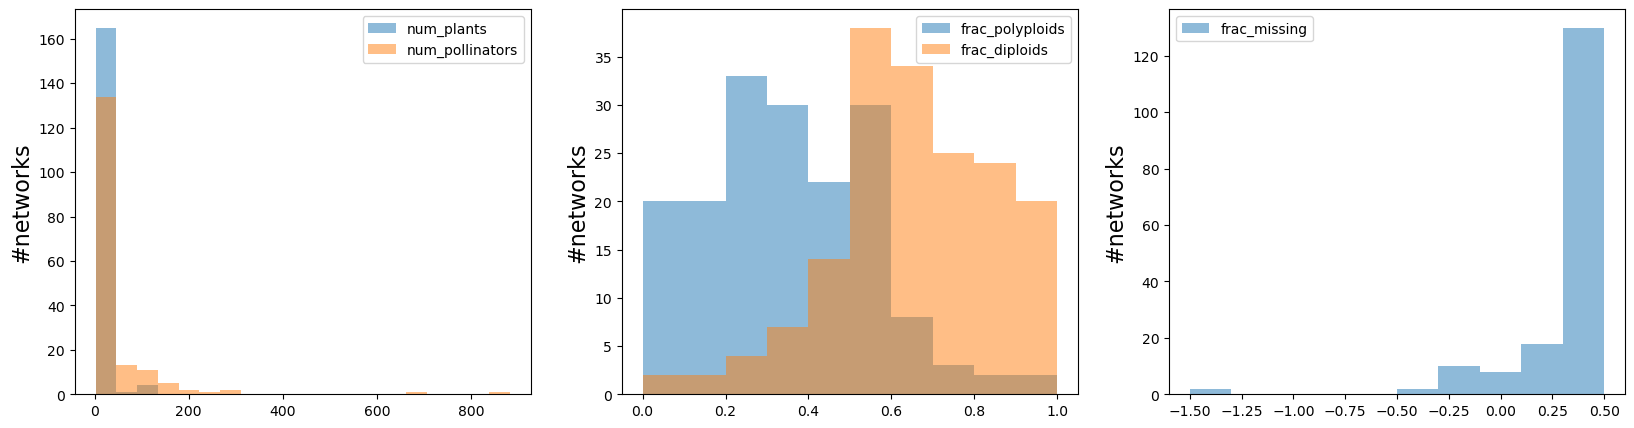

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
network_classification.loc[network_classification.frac_missing <= 0.5][["num_plants", "num_pollinators"]].plot(kind='hist', bins=20, stacked=False, alpha=.5, ax=axes[0])
axes[0].set_ylabel("#networks", fontsize=16)
network_classification.loc[network_classification.frac_missing <= 0.5][["frac_polyploids", "frac_diploids"]].plot(kind='hist', bins=10, stacked=False, alpha=.5, ax=axes[1])
axes[1].set_ylabel("#networks", fontsize=16)
network_classification.loc[network_classification.frac_missing <= 0.5][["frac_missing"]].plot(kind='hist', bins=10, stacked=False, alpha=.5, ax=axes[2])
axes[2].set_ylabel("#networks", fontsize=16)

<AxesSubplot:>

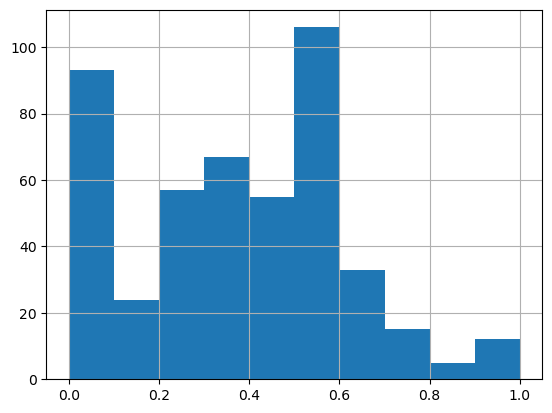

In [17]:
network_classification.frac_polyploids.hist()

In [18]:
network_classification.to_csv("./network_classification.csv", index=False)

# deprecated - attempt to find missing classifications in q db

In [19]:
qdb = pd.read_excel(qdb_path)

In [20]:
qdb["taxon"] = qdb[["Genus", "Species", "Subspecies"]].apply(lambda record: f"{record.Genus} {record.Species} {'' if pd.isna(record.Subspecies) else record.Subspecies}".lower(), axis=1)

In [21]:
missing_resolved_names = classified_resolved_plant_names.loc[classified_resolved_plant_names.is_polyploid.isna()].resolved_Species.tolist()
missing_unresolved_names = classified_unresolved_plant_names.loc[classified_unresolved_plant_names.is_polyploid.isna()].Species.tolist()

In [22]:
qdb_complementary_data_by_resolved_names = qdb.loc[qdb.taxon.isin(missing_resolved_names)]
qdb_complementary_data_by_unresolved_names = qdb.loc[qdb.taxon.isin(missing_unresolved_names)]

print(f"qdb has {qdb_complementary_data_by_resolved_names.shape[0]:,} resolved names ploidy level that is missing from ploidb")
print(f"qdb has {qdb_complementary_data_by_unresolved_names.shape[0]:,} unresolved names ploidy level that is missing from ploidb")

qdb has 0 resolved names ploidy level that is missing from ploidb
qdb has 5 unresolved names ploidy level that is missing from ploidb


In [23]:
qdb_complementary_data_by_unresolved_names

,Higher Group,Genus,Species,Subspecies,Family (APG III),Order,1C-value (pg),Life cycle,Chromosome number (2n) (if reported),Chromosome Footnote,Ploidy level (x),Ploidy Footnote,Estimation Method,Original reference No.,Reference,taxon
1507,E,Phytolacca,rivinoides,NaN,Phytolaccaceae,Caryophyllales,1.3,P,36.0,NaN,4.0,NaN,Fe,354.0,"Poggio L, Greizerstein EJ, Bottini MCJ, Guagli...",phytolacca rivinoides
1701,E,Momordica,charantia,NaN,Cucurbitaceae,Cucurbitales,2.1,A,22.0,o,2.0,z,Fe,69.0,"Ingle J, Timmis JN, Sinclair J. 1975. Relatio...",momordica charantia
1798,E,Viburnum,opulus,NaN,Adoxaceae,Dipsacales,4.1,P,18.0,o,2.0,z,Fe,154.0,Band SR. (pers. comm. 1984).,viburnum opulus
3688,E,Caltha,palustris,NaN,Ranunculaceae,Ranunculales,16.5,P,56.0,o,7.0,z,Fe,1.0,Bennett MD. 1972. Nuclear DNA content and min...,caltha palustris
8248,E,Petasites,frigidus,NaN,Asteraceae,Asterales,3.2,P,NaN,n,NaN,p,FC:PI,721.0,"Bai C, Alverson WS, Follansbee A, Waller DM. 2...",petasites frigidus


# deprecated - check which names without ploidy level can have their ploidy level inferred based on their parent node

In [24]:
names_with_missing_classification = classified_resolved_plant_names.loc[classified_resolved_plant_names.is_polyploid.isna()].unresolved_Species.tolist()

In [25]:
tree = Tree(tree_path, format=1)
ccdb = pd.read_csv(ccdb_path)
classification_data = pd.read_csv(classification_data_path)

In [26]:
for leaf in tree.get_leaves():
    leaf.name = leaf.name.lower().replace("_"," ")
leaf_names = set(tree.get_leaf_names())
names_present_in_tree = [n for n in names_with_missing_classification if n in leaf_names]

In [27]:
# for each name present in the tree, check if there is a sibling with available chromosome count
names_that_can_be_inferred = []
for name in names_present_in_tree:
    node = tree.search_nodes(name=name)[0]
    parent = node.up
    siblings = set(parent.get_leaf_names())-set([name])
    if ccdb.loc[ccdb.mapped_name.isin(siblings)].shape[0] > 0:
        names_that_can_be_inferred.append(name)
print(f"# names for which ploidy inference can be reliably extracted based on parent node = {len(names_that_can_be_inferred):,}")

# names for which ploidy inference can be reliably extracted based on parent node = 758


In [28]:
df = pd.DataFrame(columns=["name", "genus", "family"])
df.name = names_that_can_be_inferred
df.genus = df.name.apply(lambda name: name.split(" ")[0])
df.set_index("genus", inplace=True)
df.family.fillna(classification_data.set_index("genus")["family"].to_dict(), inplace=True)
df.reset_index(inplace=True)

In [29]:
df.to_csv(missing_names_path, index=False)

In [12]:
plant_classification_data = pd.read_csv("/groups/itay_mayrose/halabikeren/plant_pollinator_networks/classification/plant_classification_data.csv")
plant_name_to_class = plant_classification_data.set_index("original_name")["conservative_is_polyploid_by_resolved"].to_dict()

In [13]:
plant_network_data = pd.read_csv("/groups/itay_mayrose/halabikeren/plant_pollinator_networks/features/taxonomic_features/taxonomic_features.csv", usecols=["original_name","network_type","network_id"])
plant_network_data["is_polyploid"] = np.nan
plant_network_data.set_index("original_name", inplace=True)
plant_network_data.is_polyploid.fillna(plant_name_to_class, inplace=True)
plant_network_data.reset_index(inplace=True)

In [26]:
network_classification_data = plant_network_data.groupby(["network_type","network_id"])["is_polyploid"].apply(lambda x: np.any(x==1)).reset_index().rename(columns={"is_polyploid":"has_polyploids"})
binary_network_classification_data = df.query("network_type == 'binary'").drop(["network_type"], axis=1)
weighted_network_classification_data = df.query("network_type == 'weighted'").drop(["network_type"], axis=1)
binary_network_classification_data.to_csv("./binary_network_classification.csv", index=False)
weighted_network_classification_data.to_csv("./weighted_network_classification.csv", index=False)